# Machine Learning - Project - Group MAA_202021_10
## Group Members
|Name|StudentID|
|:-----------:|:--------:|
|Fabio Lopes|20200597|
|Filipe Costa|20201041|
|Jorge Pereira|20201085|

## Introduction 
Put some introduction here

## Package Instalation and Importing

In [353]:
import sys
#!{sys.executable} -m pip install -U xlrd
#!{sys.executable} -m pip install -U xgboost
#!{sys.executable} -m pip install -U hyperopt
#!{sys.executable} -m pip install -U mlflow
#!{sys.executable} -m pip install -U imbalanced-learn
#!{sys.executable} -m pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [354]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import time

from sklearn.model_selection import train_test_split, cross_val_score,cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import CondensedNearestNeighbour, RandomUnderSampler

from xgboost import XGBClassifier

import matplotlib.pyplot as plt

from collections import Counter

from hyperopt import STATUS_OK, fmin, hp, tpe, Trials

In [355]:
data = pd.read_excel('Train.xlsx')
data_test = pd.read_excel("Test.xlsx")

In [356]:
print(f"Training data has {data.shape[1]} columns and {data.shape[0]} rows.")

Training data has 15 columns and 22400 rows.


## Data Cleansing & Feature Engineering Functions
In this section, we will define the Cleansing functions

In [357]:
def strip_lower(df):
    """Detects the String columns and converts all the records to lowercase."""
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(str.strip).apply(str.lower)
    return df

In [358]:
def fill_missing_values(df,ColumnswithMissingValues):
    for column in ColumnswithMissingValues:
        ColumnMode = df[column].mode()[0]
        df[column] = df[column].str.replace('?',ColumnMode, regex=False)
    return df

In [359]:
def ComputeAgeAt2048(Birthday):
    CurrentYear=datetime(2048,1,1)
    
    s_YearOfBirth = Birthday.split(",")[1]
    YearOfBirth = datetime(int(s_YearOfBirth),1,1)
        
    return CurrentYear.year - YearOfBirth.year

In [360]:
def ClassifyCitizen(Difference):
    if Difference == 0:
        return 'A' # Chosen carefully from volunteers
    elif Difference > 0:
        return 'B' # Invited
    elif Difference < 0:
        return 'C' # Paid

In [361]:
def encode_data(data, nominal_variables):
    data_Encoded = data.copy()
    dummies = pd.get_dummies(data_Encoded[nominal_variables], prefix=nominal_variables)
    data_Encoded = pd.concat([data_Encoded,dummies],axis=1)
    data_Encoded = data_Encoded.drop(nominal_variables, axis =1)
    return data_Encoded

In [362]:
def AlignDataframe(ColumnsInModel,df):
    dummy_df = pd.DataFrame(columns=ColumnsInModel)
    dummy_df, aligned_df = dummy_df.align(df,fill_value=0,join='left',axis=1)
    return aligned_df

In [363]:
def MaritalStatusNormalization(Mstatus):
    if Mstatus == 'married':
        return 'married'
    elif Mstatus == 'single':
        return 'not_married'
    elif Mstatus == 'divorced':
        return 'not_married'
    elif Mstatus == 'separated':
        return 'not_married'
    elif Mstatus == 'widow':
        return 'not_married'
    elif Mstatus == 'married - spouse missing':
        return 'married'
    elif Mstatus == 'married - spouse in the army':
        return 'married'
    else:
        return 'NA'

In [364]:
def LivesWithNormalization(Lwith):
    if Lwith == 'wife':
        return 'spouse'
    elif Lwith == 'other family':
        return 'other'
    elif Lwith == 'children':
        return 'children'
    elif Lwith == 'alone':
        return 'alone'
    elif Lwith == 'husband':
        return 'spouse'
    elif Lwith == 'other relatives':
        return 'other'
    else:
        return 'NA'

In [365]:
def Sector(S):
    if S == 'private sector - services':
        return 'private'
    elif S == 'self-employed (individual)':
        return 'self'
    elif S == 'public sector - others':
        return 'public'
    elif S == 'private sector - others':
        return 'private'
    elif S == 'self-employed (company)':
        return 'self'
    elif S == 'public sector - government':
        return 'public'
    elif S == 'unemployed':
        return 'None'
    elif S == 'never worked':
        return 'None'
    else:
        return 'NA'

In [366]:
def DataPreProcessing(data):
    # Lowers all case in string variables
    new_df = data.copy()

    new_df = strip_lower(new_df)

    # Deals with missing values
    ColumnswithMissingValues = ['Role','Employment Sector','Base Area']
    new_df = fill_missing_values(new_df,ColumnswithMissingValues)

    # Computes Age
    new_df['Age'] = new_df['Birthday'].apply(ComputeAgeAt2048)
    new_df.drop('Birthday', axis=1, inplace=True)

    # Classifies Citizen
    new_df['Group'] = (new_df['Money Received'] - new_df['Ticket Price']).apply(ClassifyCitizen)

    # Marital Status Normalization
    new_df['MStatus'] = new_df['Marital Status'].apply(MaritalStatusNormalization)
    new_df.drop('Marital Status', axis=1, inplace=True)

    # Lives With Normalization
    new_df['Lwith'] = new_df['Lives with'].apply(LivesWithNormalization)
    new_df.drop('Lives with', axis=1, inplace=True)

    # Employment Sector Normalization
    new_df['Sector'] = new_df['Employment Sector'].apply(Sector)
    new_df.drop('Employment Sector', axis=1, inplace=True)

    # Creates Ordinal Variable from Education
    EducationClassification = {
                            "phd" : 16,
                            "masters + postgraduation" : 15,
                            "masters" : 14,
                            "bachelors + postgraduation" : 13,
                            "bachelors" : 12,
                            "professional school + postgraduation" : 11,
                            "high school + postgraduation" : 10,
                            "professional school" : 9,
                            "high school complete" : 8,
                            "high school - 2nd cycle" : 7,
                            "high school - 1st cycle" : 6,
                            "middle school complete" : 5,
                            "middle school - 2nd cycle" : 4,
                            "middle school - 1st cycle" : 3,
                            "primary school" : 2,
                            "preschool" : 1
                            }
    new_df['Education_Class'] = new_df['Education Level'].map(EducationClassification)
    new_df.drop('Education Level', axis=1, inplace=True)

    # Performs one hot encoding in nominal variables
    NominalVariables = ['Native Continent', 
                        'Role', 
                        'MStatus', 
                        'Lwith', 
                        'Sector', 
                        'Group']

    new_df = encode_data(new_df, NominalVariables)

    # Drops the Name column and selects Citizen ID as the index
    new_df = new_df.drop(['Name'], axis =1)
    new_df = new_df.drop(['Base Area'], axis =1)
    new_df.set_index(["CITIZEN_ID"],inplace=True)

    # Scale Data
#     if 'Income' in new_df.columns:
#         featuresToScale = new_df.columns.drop('Income')
#     else:
#         featuresToScale = new_df.columns
#     new_df = MinMaxScaler_df(new_df,featuresToScale)

    return new_df.copy()

In [367]:
processedTrainingData = DataPreProcessing(data)
processedTestingData = DataPreProcessing(data_test)

In [368]:
processedTrainingData.head(5)

,Years of Education,Working Hours per week,Money Received,Ticket Price,Income,Age,Education_Class,Native Continent_africa,Native Continent_america,Native Continent_asia,...,Lwith_children,Lwith_other,Lwith_spouse,Sector_None,Sector_private,Sector_public,Sector_self,Group_A,Group_B,Group_C
CITIZEN_ID,,,,,,,,,,,,,,,,,,,,,
12486,13,40,0,2273,1,45,10,0,0,0,...,0,0,1,0,1,0,0,0,0,1
12487,12,40,0,0,1,42,9,0,0,0,...,0,0,1,0,0,1,0,1,0,0
12488,12,46,0,2321,1,39,9,0,0,0,...,0,0,1,0,1,0,0,0,0,1
12489,11,37,5395,0,1,63,7,0,0,0,...,0,0,1,0,1,0,0,0,1,0
12490,21,45,0,0,1,33,16,0,0,0,...,0,1,0,0,0,0,1,1,0,0


## Model Creation
In this section, we will create the models.

In [438]:
def runModels(models,X,y,X_test,y_test):

    GlobalTimerStart = time.time()
    ModelPerf = []
    for model in models:
        print(f"Running Model: {type(model).__name__}")
        LocalTimerStart = time.time()
        model.fit(X,y)
        scoresf1w = cross_validate(model, X,y, cv=10,scoring=('f1_micro'))
        labels_val = model.predict(X_test)
        ModelPerf.append((type(model).__name__,
                          'Train',
                          scoresf1w['test_score'].mean()
        ))
        ModelPerf.append((type(model).__name__,
          'Test',
          f1_score(y_test, labels_val, average='micro')
        ))
        
        LocalTimerEnd = time.time()
        print(f"-- Done. Duration: {LocalTimerEnd-LocalTimerStart} s")
    GlobalTimerEnd = time.time()
    print(f"GLOBAL DURATION: {GlobalTimerEnd-GlobalTimerStart} s")
    
    res = pd.DataFrame(ModelPerf,columns=['model','Stage','f1_micro'])
    
    fig = plt.figure(figsize=(20, 10))
    graph = sns.barplot(x="model", y="f1_micro", hue="Stage", data=res)
    graph.legend(loc='lower left')
    for bar in graph.patches:
        graph.annotate(format(bar.get_height(), '.4f'), 
                       (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -12),
                       color="white",
                       textcoords = 'offset points')

    graph.set_xticklabels(graph.get_xticklabels(),
                          rotation=45,
                          horizontalalignment='center',
                          fontweight='light')
    
    return res

### Correlation

In [370]:
corr_df = processedTrainingData[['Ticket Price','Working Hours per week', 'Money Received','Years of Education',
       'Ticket Price', 'Income', 'Age', 'Education_Class','Group_A', 'Group_B', 'Group_C']].corr()
corr_df

,Ticket Price,Working Hours per week,Money Received,Years of Education,Ticket Price,Income,Age,Education_Class,Group_A,Group_B,Group_C
Ticket Price,1.000000,0.052959,-0.031330,0.084810,1.000000,0.155890,0.055774,0.081762,-0.567060,-0.065122,0.980514
Working Hours per week,0.052959,1.000000,0.075471,0.138516,0.052959,0.219890,0.064900,0.144922,-0.092201,0.074887,0.048958
Money Received,-0.031330,0.075471,1.000000,0.123015,-0.031330,0.221440,0.072693,0.118556,-0.373136,0.481099,-0.031953
Years of Education,0.084810,0.138516,0.123015,1.000000,0.084810,0.333089,0.035241,0.984065,-0.142698,0.111686,0.081220
Ticket Price,1.000000,0.052959,-0.031330,0.084810,1.000000,0.155890,0.055774,0.081762,-0.567060,-0.065122,0.980514
Income,0.155890,0.219890,0.221440,0.333089,0.155890,1.000000,0.233157,0.330227,-0.305667,0.263008,0.143257
Age,0.055774,0.064900,0.072693,0.035241,0.055774,0.233157,1.000000,0.031290,-0.125038,0.115570,0.048285
Education_Class,0.081762,0.144922,0.118556,0.984065,0.081762,0.330227,0.031290,1.000000,-0.139703,0.110063,0.078583
Group_A,-0.567060,-0.092201,-0.373136,-0.142698,-0.567060,-0.305667,-0.125038,-0.139703,1.000000,-0.775591,-0.578330
Group_B,-0.065122,0.074887,0.481099,0.111686,-0.065122,0.263008,0.115570,0.110063,-0.775591,1.000000,-0.066417


In [371]:
corr_df = processedTrainingData[['Ticket Price','Working Hours per week', 'Money Received','Years of Education',
       'Ticket Price', 'Income', 'Age', 'Education_Class','Group_A', 'Group_B', 'Group_C']].corr()
corr_df
#High correlation between Ticket Price and Group_C. We can remove one of then
#Also high correlation between Years of Education and Education class
processedTrainingData = processedTrainingData.drop(['Group_C','Education_Class'],axis=1)

In [372]:
corr_df = processedTrainingData.corr()['Income']
low_corr_cols =[]
for col in list(corr_df.index):
    if(np.abs(corr_df[col]) < 0.1):
        low_corr_cols.append(col)

In [373]:
processedTrainingData = processedTrainingData.drop(low_corr_cols,axis=1)

### Outliers

In [374]:
#Outliers
Q1 = processedTrainingData.quantile(0.25)
Q3 = processedTrainingData.quantile(0.75)
IQR = Q3 - Q1
IQR = IQR[IQR > 0]
IQR

Years of Education         3.0
Working Hours per week     5.0
Age                       20.0
MStatus_married            1.0
MStatus_not_married        1.0
Lwith_other                1.0
Lwith_spouse               1.0
dtype: float64

In [375]:
IQR = IQR[['Years of Education','Working Hours per week','Age']]
processedTrainingData = processedTrainingData[~((processedTrainingData < (Q1 - 1.5 * IQR)) |(processedTrainingData > (Q3 + 1.5 * IQR))).any(axis=1)]

### Split Training Data

In [376]:
target = 'Income'

X = processedTrainingData[[x for x in processedTrainingData.columns if x != target]]
y = processedTrainingData[[x for x in processedTrainingData.columns if x == target]]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [377]:
# Backup the Source datasets
X_train_source = X_train.copy()
X_test_source = X_test.copy()
y_train_source = y_train.copy()
y_test_source = y_test.copy()

# MODEL DEFINITION

In [378]:
modellog = LogisticRegression(max_iter=1000000)
modelKNN = KNeighborsClassifier()
modelTree = DecisionTreeClassifier()
modelSVC = SVC()
modelNAB = GaussianNB()
modelRF = RandomForestClassifier()
modelGBC = GradientBoostingClassifier()
modelAda = AdaBoostClassifier()
modelMLP = MLPClassifier(max_iter=500)
modelLDA = LinearDiscriminantAnalysis()
modelBagging = BaggingClassifier()

# Run All Models, without over/under sampling and without scaling

Running Model: LogisticRegression
-- Done. Duration: 54.106624364852905 s
Running Model: KNeighborsClassifier
-- Done. Duration: 7.940873861312866 s
Running Model: DecisionTreeClassifier
-- Done. Duration: 0.809551477432251 s
Running Model: SVC
-- Done. Duration: 50.26394462585449 s
Running Model: GaussianNB
-- Done. Duration: 0.30767107009887695 s
Running Model: RandomForestClassifier
-- Done. Duration: 21.18921422958374 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 20.432403087615967 s
Running Model: AdaBoostClassifier
-- Done. Duration: 8.874149084091187 s
Running Model: LinearDiscriminantAnalysis
-- Done. Duration: 0.8451666831970215 s
Running Model: BaggingClassifier
-- Done. Duration: 4.994716644287109 s
GLOBAL DURATION: 169.7688376903534 s


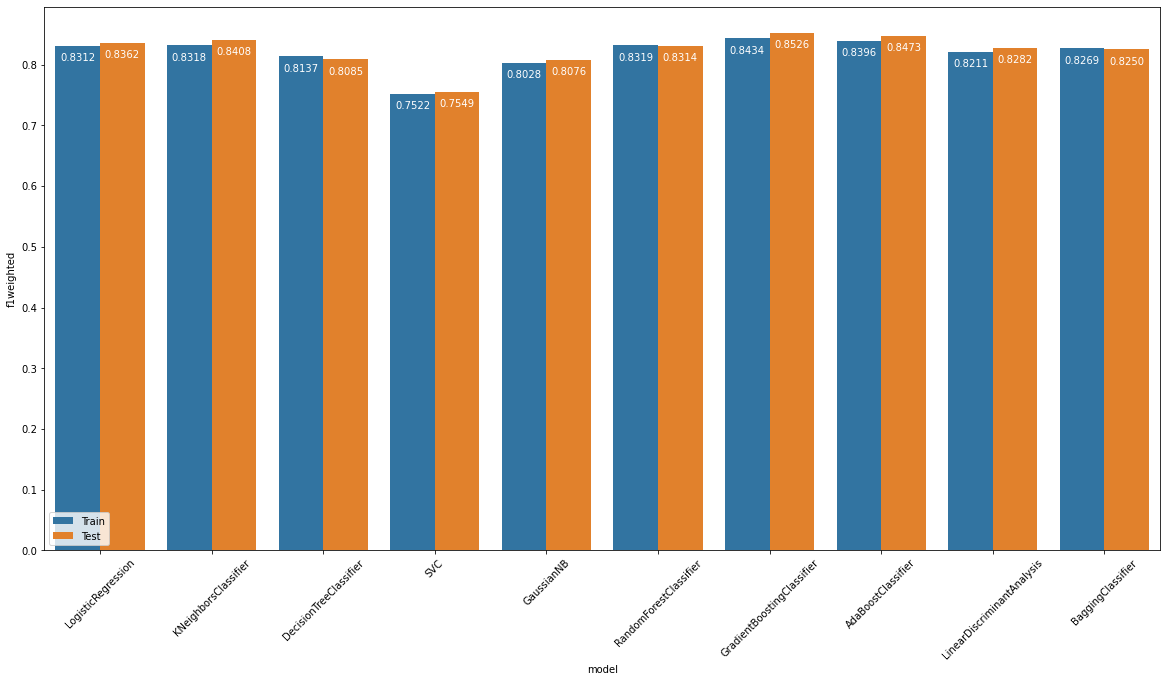

In [379]:
models = [  modellog,
            modelKNN,
            modelTree,
            modelSVC,
            modelNAB,
            modelRF,
            modelGBC,
            modelAda,
            #modelMLP, Too slow, will only put it there in the final version
            modelLDA,
            modelBagging]

DEFAULT_res = runModels(models,X_train,y_train,X_test,y_test)

## Rebalance Dataset

In [380]:
counter = Counter(y_train)
print(counter)

Counter({0: 8233, 1: 2734})


### Using SMOTE to rebalance dataset

In [381]:
oversample = SMOTE()
SMOTE_X_train, SMOTE_y_train = oversample.fit_resample(X_train, y_train)
counter = Counter(SMOTE_y_train)
print(counter)

Counter({0: 8233, 1: 8233})


Running Model: DecisionTreeClassifier
-- Done. Duration: 1.1397109031677246 s
Running Model: RandomForestClassifier
-- Done. Duration: 28.574435710906982 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 30.385019063949585 s
Running Model: AdaBoostClassifier
-- Done. Duration: 12.882578372955322 s
GLOBAL DURATION: 72.98174405097961 s


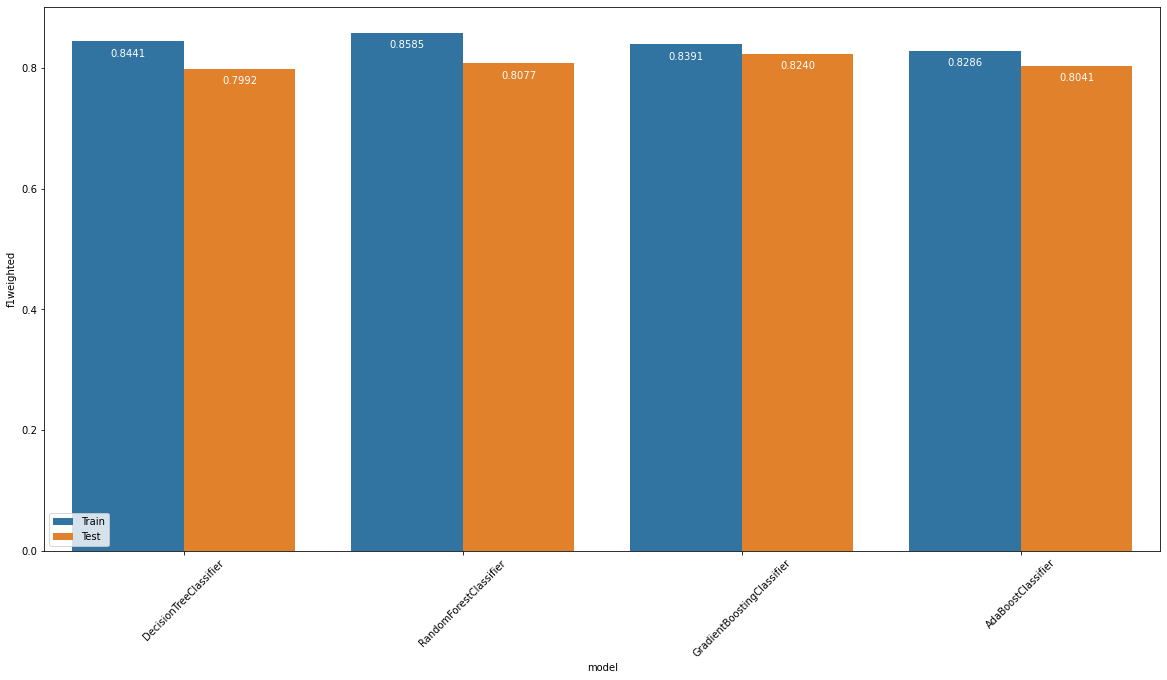

In [382]:
models = [modelTree,
          modelRF,
          modelGBC,
          modelAda
         ]

SMOTE_res = runModels(models,SMOTE_X_train,SMOTE_y_train,X_test,y_test)

### Using ADASYN to rebalance dataset

In [383]:
oversample = ADASYN()
ADASYN_X_train, ADASYN_y_train = oversample.fit_resample(X_train, y_train)
counter = Counter(ADASYN_y_train)
print(counter)

Counter({0: 8233, 1: 7864})


Running Model: DecisionTreeClassifier
-- Done. Duration: 1.2239737510681152 s
Running Model: RandomForestClassifier
-- Done. Duration: 29.870440244674683 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 28.34213423728943 s
Running Model: AdaBoostClassifier
-- Done. Duration: 11.557993650436401 s
GLOBAL DURATION: 71.00011444091797 s


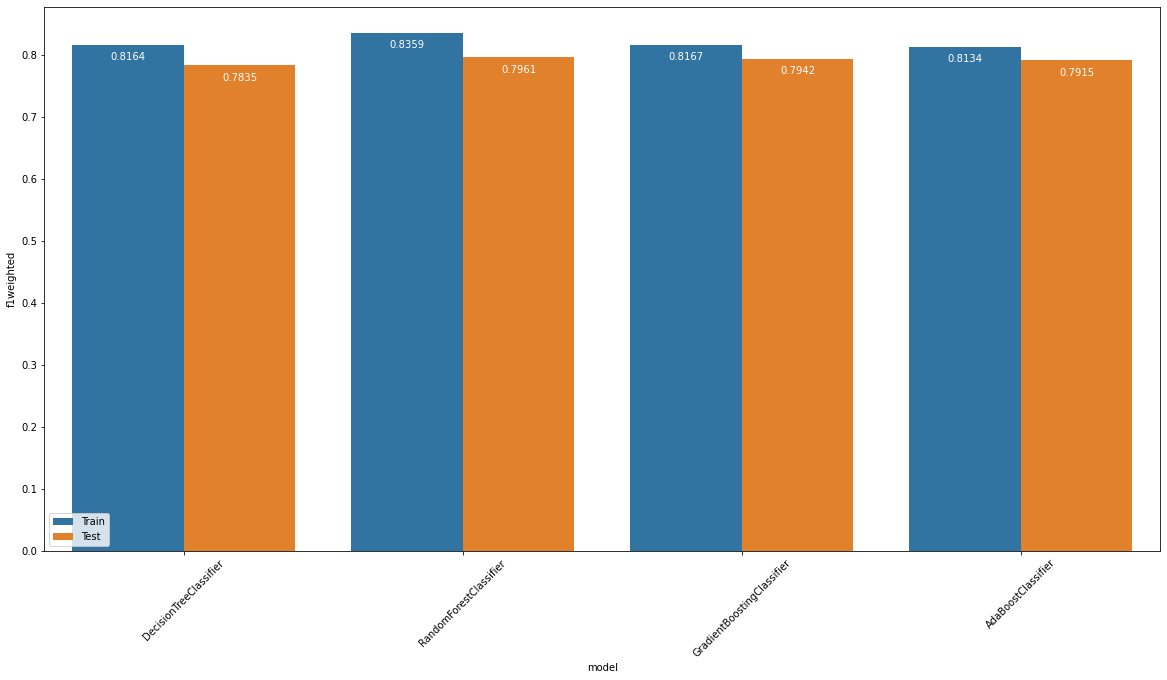

In [384]:
models = [modelTree,
          modelRF,
          modelGBC,
          modelAda
         ]

ADASYN_res = runModels(models,ADASYN_X_train,ADASYN_y_train,X_test,y_test)

### Using Random Under Sampler

In [385]:
RUS = RandomUnderSampler()
RUS_X_train, RUS_y_train = RUS.fit_resample(X_train, y_train)

counter = Counter(RUS_y_train)
print(counter)

Counter({0: 2734, 1: 2734})


Running Model: DecisionTreeClassifier
-- Done. Duration: 0.47680020332336426 s
Running Model: RandomForestClassifier
-- Done. Duration: 12.830326080322266 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 11.1399827003479 s
Running Model: AdaBoostClassifier
-- Done. Duration: 5.644926071166992 s
GLOBAL DURATION: 30.092035055160522 s


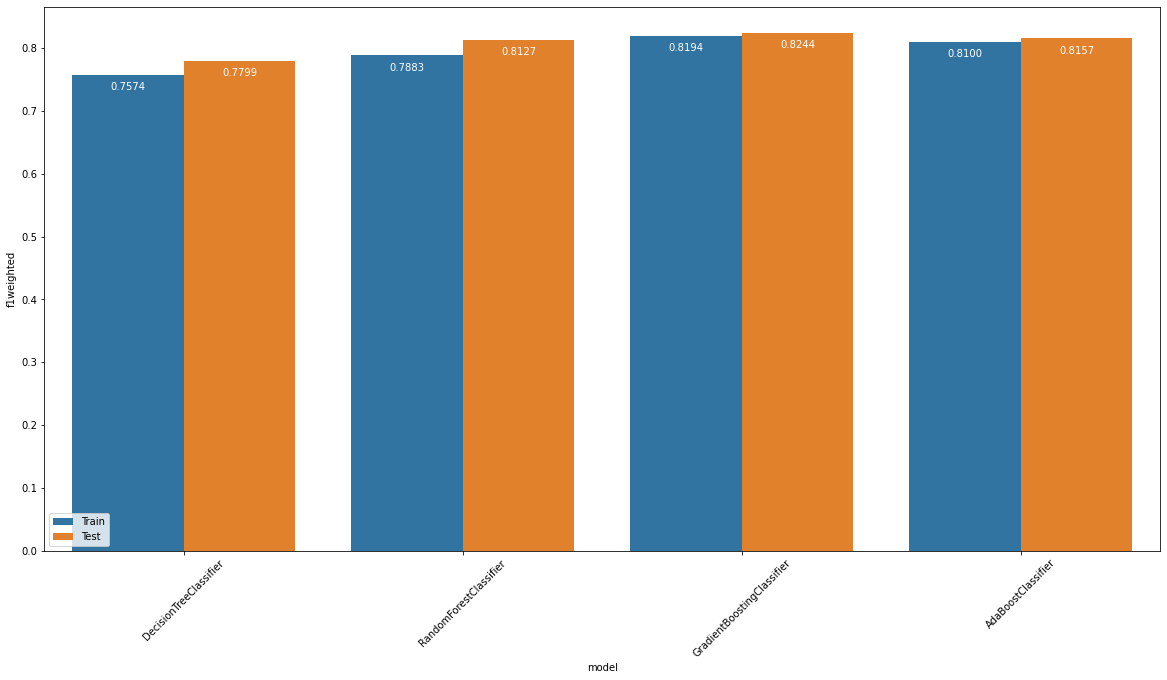

In [386]:
models = [modelTree,
          modelRF,
          modelGBC,
          modelAda
         ]

RUS_res = runModels(models,RUS_X_train,RUS_y_train,X_test,y_test)

### Using Tomek Links to undersample data

In [387]:
from imblearn.under_sampling import TomekLinks

TKL = TomekLinks()
TKL_X_train, TKL_y_train = TKL.fit_resample(X_train, y_train)

counter = Counter(TKL_y_train)
print(counter)

Counter({0: 8078, 1: 2734})


Running Model: DecisionTreeClassifier
-- Done. Duration: 0.7868330478668213 s
Running Model: RandomForestClassifier
-- Done. Duration: 21.043501138687134 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 20.286914587020874 s
Running Model: AdaBoostClassifier
-- Done. Duration: 8.676424264907837 s
GLOBAL DURATION: 50.793673038482666 s


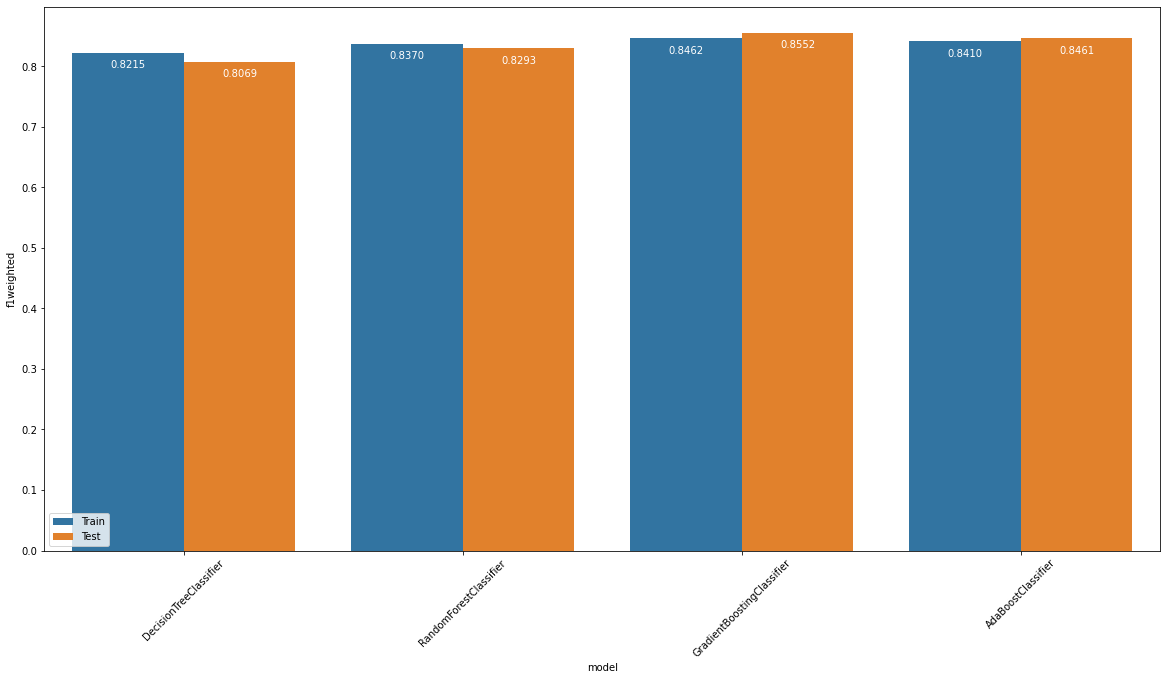

In [388]:
models = [modelTree,
          modelRF,
          modelGBC,
          modelAda
         ]

TKL_res = runModels(models,TKL_X_train,TKL_y_train,X_test,y_test)

### Using NearMiss to undersample data

In [389]:
from imblearn.under_sampling import AllKNN

NM = AllKNN()
NM_X_train, NM_y_train = NM.fit_resample(X_train, y_train)

counter = Counter(NM_y_train)
print(counter)

Counter({0: 6602, 1: 2734})


Running Model: DecisionTreeClassifier
-- Done. Duration: 0.6979143619537354 s
Running Model: RandomForestClassifier
-- Done. Duration: 16.760032176971436 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 17.53488826751709 s
Running Model: AdaBoostClassifier
-- Done. Duration: 7.535423278808594 s
GLOBAL DURATION: 42.528258085250854 s


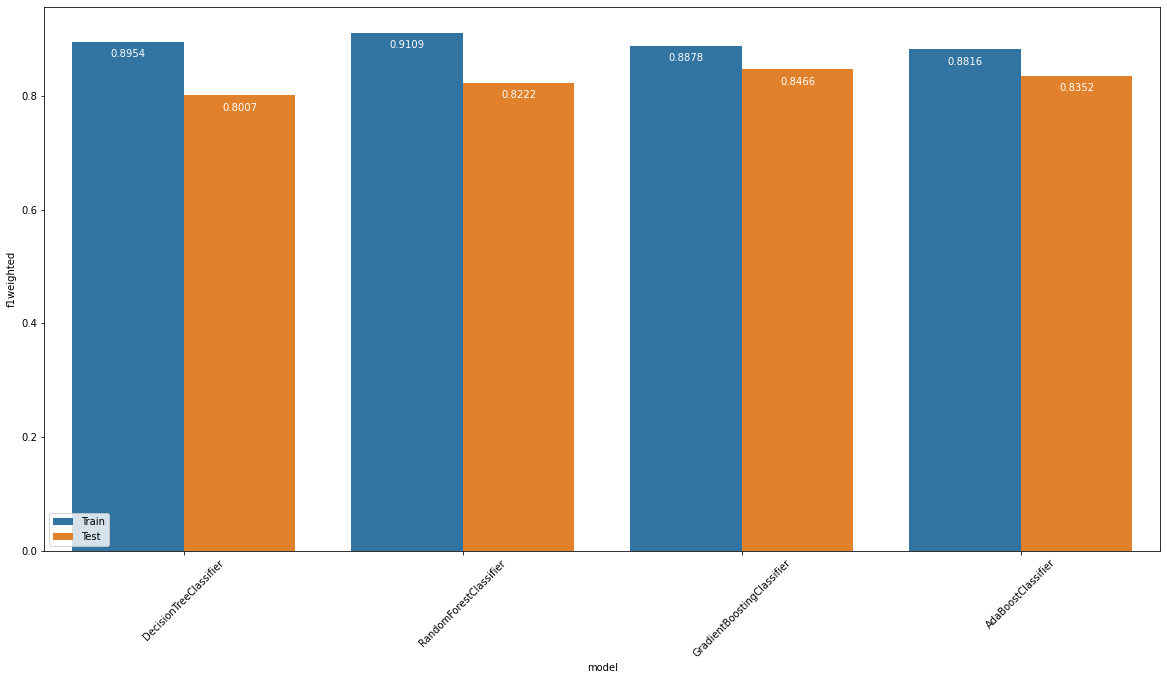

In [390]:
models = [modelTree,
          modelRF,
          modelGBC,
          modelAda
         ]

NM_res = runModels(models,NM_X_train,NM_y_train,X_test,y_test)

### Choose 1 method

In [391]:
X_train = TKL_X_train
y_train = TKL_y_train

## Data Scaling

### StandardScaler

In [392]:
scaler = StandardScaler()
SScale_X_train = scaler.fit_transform(X_train)
SScale_X_test = scaler.fit_transform(X_test)
SScale_y_train = y_train
SScale_y_test = y_test

Running Model: DecisionTreeClassifier
-- Done. Duration: 0.7134733200073242 s
Running Model: RandomForestClassifier
-- Done. Duration: 20.877394437789917 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 21.043076276779175 s
Running Model: AdaBoostClassifier
-- Done. Duration: 8.770240068435669 s
GLOBAL DURATION: 51.404184103012085 s


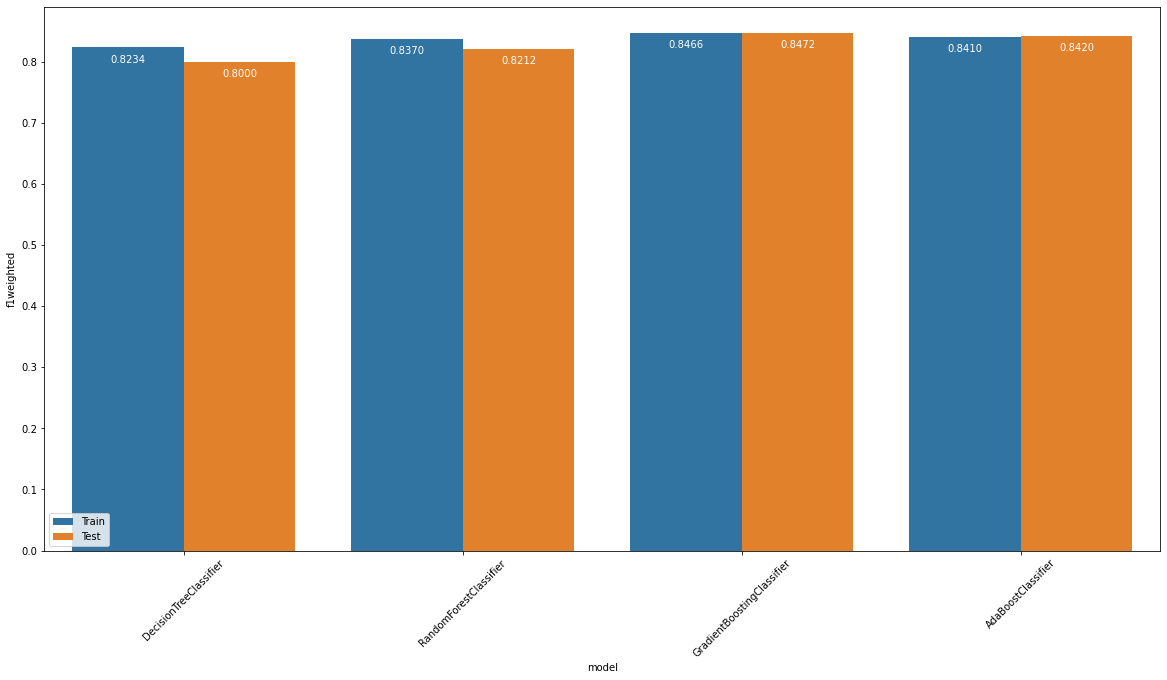

In [393]:
models = [modelTree,
          modelRF,
          modelGBC,
          modelAda
         ]

SScaler_res = runModels(models,SScale_X_train,SScale_y_train,SScale_X_test,SScale_y_test)

### MinMax 0:1

In [394]:
min_max_0_1 = MinMaxScaler(feature_range=(0, 1))
MinMaxScaler_01_X_train = min_max_0_1.fit_transform(X_train)
MinMaxScaler_01_X_test = min_max_0_1.fit_transform(X_test)
MinMaxScaler_01_y_train = y_train
MinMaxScaler_01_y_test = y_test

Running Model: DecisionTreeClassifier
-- Done. Duration: 0.7367198467254639 s
Running Model: RandomForestClassifier
-- Done. Duration: 20.83992862701416 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 20.78034281730652 s
Running Model: AdaBoostClassifier
-- Done. Duration: 8.628770589828491 s
GLOBAL DURATION: 50.99408769607544 s


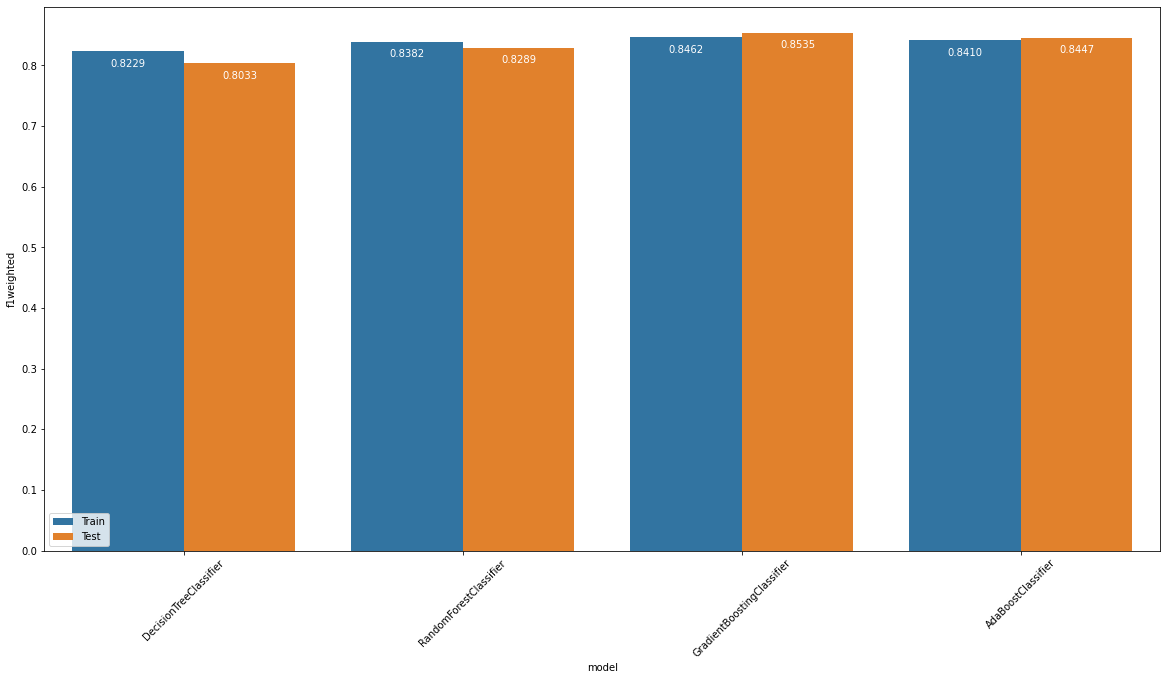

In [395]:
models = [modelTree,
          modelRF,
          modelGBC,
          modelAda
         ]

MinMaxScaler_01_res = runModels(models,MinMaxScaler_01_X_train,MinMaxScaler_01_y_train,MinMaxScaler_01_X_test,MinMaxScaler_01_y_test)

### MinMax -1:1

In [396]:
min_max_1_1 = MinMaxScaler(feature_range=(-1, 1))
MinMaxScaler_11_X_train = min_max_1_1.fit_transform(X_train)
MinMaxScaler_11_X_test = min_max_1_1.fit_transform(X_test)
MinMaxScaler_11_y_train = y_train
MinMaxScaler_11_y_test = y_test

Running Model: DecisionTreeClassifier
-- Done. Duration: 0.7651853561401367 s
Running Model: RandomForestClassifier
-- Done. Duration: 20.416604042053223 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 20.800224781036377 s
Running Model: AdaBoostClassifier
-- Done. Duration: 8.719773530960083 s
GLOBAL DURATION: 50.70487451553345 s


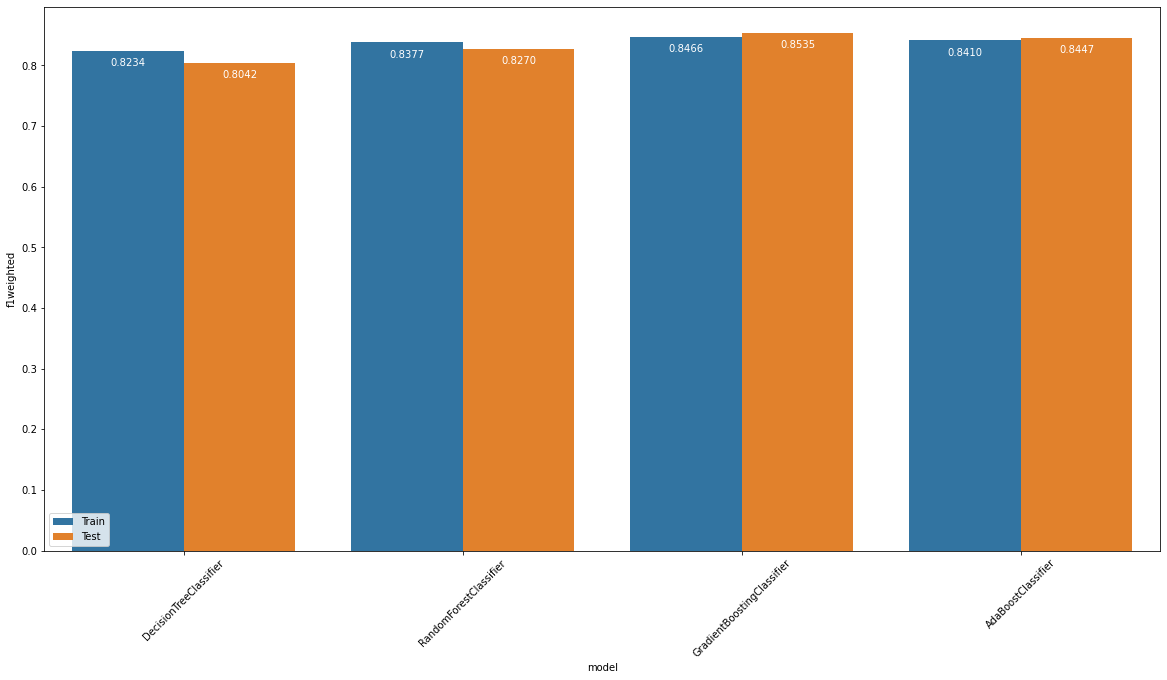

In [397]:
models = [modelTree,
          modelRF,
          modelGBC,
          modelAda
         ]

MinMaxScaler_11_res = runModels(models,MinMaxScaler_11_X_train,MinMaxScaler_11_y_train,MinMaxScaler_11_X_test,MinMaxScaler_11_y_test)

### RobustScaler

In [398]:
robust_scaler = RobustScaler()
RobScaler_X_train = robust_scaler.fit_transform(X_train)
RobScaler_X_test = robust_scaler.fit_transform(X_test)
RobScaler_y_train = y_train
RobScaler_y_test = y_test

Running Model: DecisionTreeClassifier
-- Done. Duration: 0.7203896045684814 s
Running Model: RandomForestClassifier
-- Done. Duration: 22.507737398147583 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 22.57798433303833 s
Running Model: AdaBoostClassifier
-- Done. Duration: 9.519072532653809 s
GLOBAL DURATION: 55.33199143409729 s


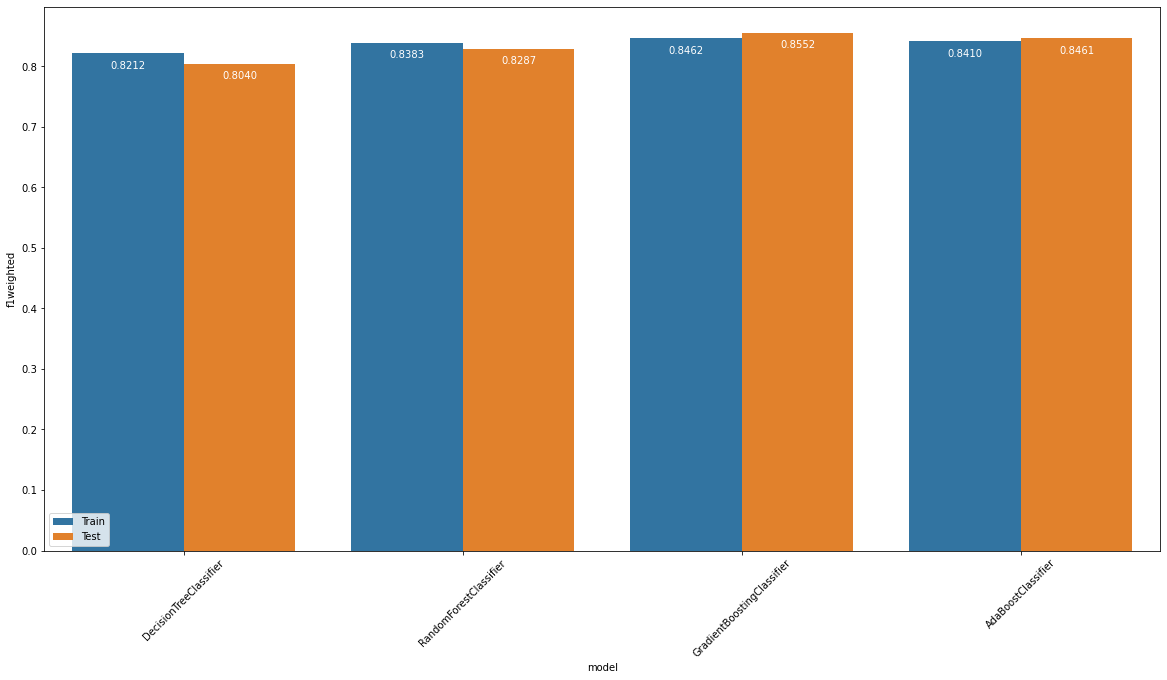

In [399]:
models = [modelTree,
          modelRF,
          modelGBC,
          modelAda
         ]

RobScaler_res = runModels(models,RobScaler_X_train,RobScaler_y_train,RobScaler_X_test,RobScaler_y_test)

In [400]:
# Choosing one:
X_train = MinMaxScaler_11_X_train
y_train = MinMaxScaler_11_y_train
X_test = MinMaxScaler_11_X_test
y_test = MinMaxScaler_11_y_test

## Feature Selection
In this section, we will eliminate noise from the model.

In [401]:
from itertools import compress
select = SelectFromModel(modelTree, threshold='mean',prefit=True)
feature_index = [i for i in range(MinMaxScaler_11_X_train.shape[1])]
features = list(compress(feature_index, select.get_support())) 
features

[0, 1, 2, 3, 4, 13]

In [402]:
len(processedTrainingData.columns)

19

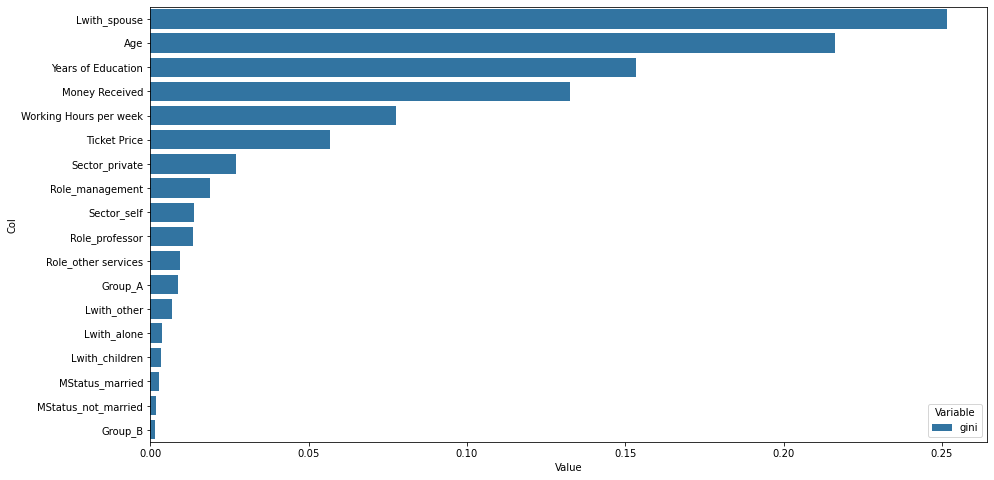

In [403]:
import seaborn as sns
columns = processedTrainingData.columns
zippy = pd.DataFrame(modelTree.feature_importances_, columns = ['gini'])
zippy['col'] = X.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

Running Model: DecisionTreeClassifier
-- Done. Duration: 0.45949673652648926 s
Running Model: RandomForestClassifier
-- Done. Duration: 19.838000297546387 s
Running Model: GradientBoostingClassifier
-- Done. Duration: 15.274571895599365 s
Running Model: AdaBoostClassifier
-- Done. Duration: 7.7294464111328125 s
GLOBAL DURATION: 43.304691791534424 s


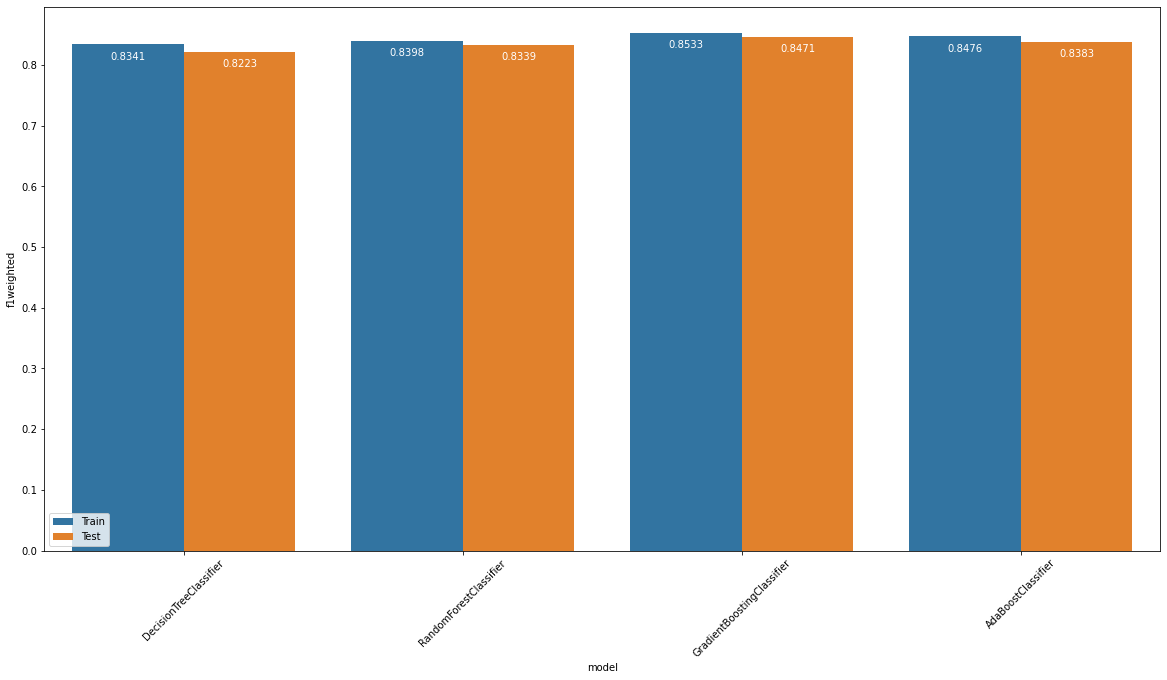

In [410]:
Selected_X_train = MinMaxScaler_11_X_train[:,features]
Selected_X_test = MinMaxScaler_11_X_test[:,features]
Selected_y_train = MinMaxScaler_11_y_train
Selected_y_Test = MinMaxScaler_11_y_test


MinMaxScaler_11_res = runModels(models,Selected_X_train,Selected_y_train,Selected_X_test,Selected_y_Test)

In [405]:
X_train = Selected_X_train
X_test = Selected_X_test
y_train = Selected_y_train
y_test = Selected_y_Test

### Hyperpatameterization

In [406]:
hyperopt_X_train = X_train
hyperopt_y_train = y_train
hyperopt_X_test = X_test
hyperopt_y_test = y_test

In [407]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# Create a pipeline
param_grid =  {   'n_estimators': [10, 20,30,100],
                 'max_depth' : [4,5,6,7,8],
                  'criterion' :['gini', 'entropy'],
                 'max_features': ['auto', 'sqrt', 'log2']}
CV_rfc = GridSearchCV(estimator=modelRF, param_grid=param_grid, cv= 5)

CV_rfc.fit(hyperopt_X_train, hyperopt_y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 20, 30, 100]})

In [352]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [427]:
modelRF = RandomForestClassifier(criterion='gini', max_depth=8, max_features='sqrt', n_estimators=100)
modelRF.fit(hyperopt_X_train, hyperopt_y_train)

RandomForestClassifier(max_depth=8, max_features='sqrt')

In [408]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch1.fit(hyperopt_X_train, hyperopt_y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': range(20, 81, 10)},
             scoring='f1_micro')

In [412]:
 gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 80}, 0.849148127857162)

In [415]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch2.fit(hyperopt_X_train, hyperopt_y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  n_estimators=80,
                                                  random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(200, 1001, 200)},
             scoring='f1_micro')

In [416]:
 gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 13, 'min_samples_split': 800}, 0.8562698790481408)

In [418]:
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=13,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='f1_micro',n_jobs=4, cv=5)
gsearch3.fit(hyperopt_X_train, hyperopt_y_train)
gsearch3.best_params_, gsearch3.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'min_samples_leaf': 30, 'min_samples_split': 1000}, 0.9059391419985555)

In [423]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt', n_estimators=80,max_depth=13, min_samples_split=1000, min_samples_leaf=30, random_state=10),
param_grid = param_test5, scoring='f1_micro',n_jobs=4, cv=5)
gsearch5.fit(hyperopt_X_train, hyperopt_y_train)
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.9}, 0.8543277893322351)

In [425]:
modelGB =  GradientBoostingClassifier(learning_rate=0.1,subsample=0.9,max_features='sqrt', n_estimators=80,max_depth=13, min_samples_split=1000, min_samples_leaf=30, random_state=10)
modelGB.fit(hyperopt_X_train, hyperopt_y_train)

GradientBoostingClassifier(max_depth=13, max_features='sqrt',
                           min_samples_leaf=30, min_samples_split=1000,
                           n_estimators=80, random_state=10, subsample=0.9)

In [443]:
modelGB = GradientBoostingClassifier(min_samples_leaf= 30, min_samples_split= 1000,learning_rate=0.1, n_estimators=80,max_depth=13,max_features='sqrt', subsample=0.8, random_state=10) 


Running Model: GradientBoostingClassifier
-- Done. Duration: 13.726586103439331 s
Running Model: RandomForestClassifier
-- Done. Duration: 13.655587911605835 s
GLOBAL DURATION: 27.384777069091797 s


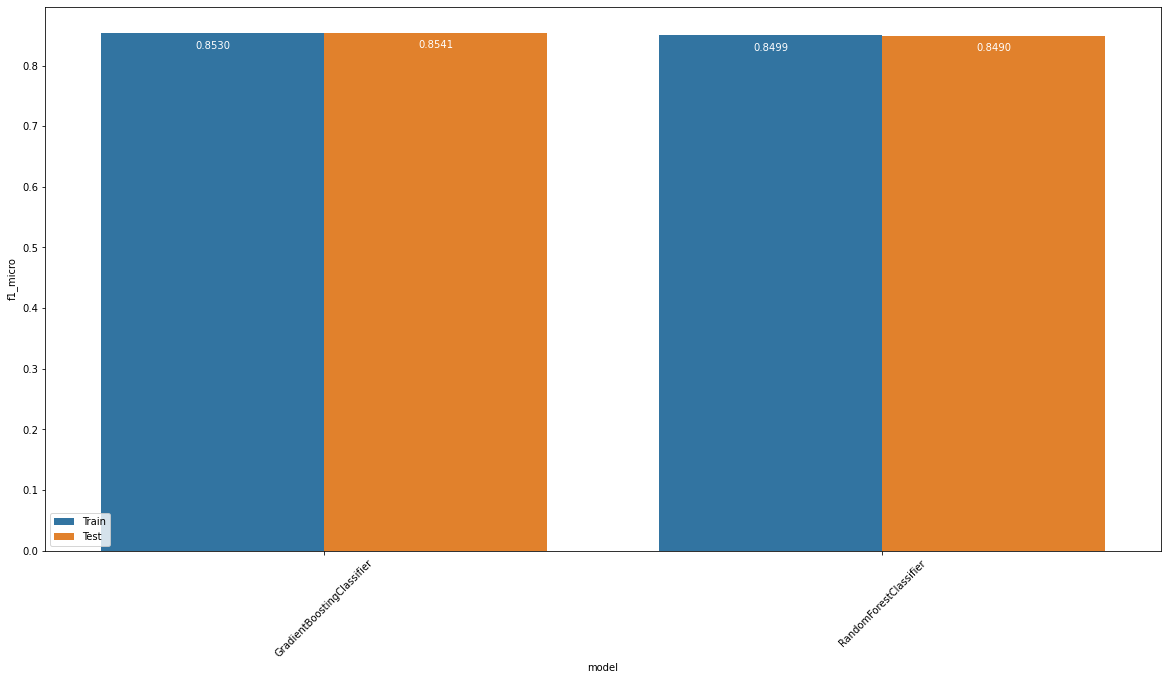

In [444]:
models = [modelGB,modelRF]
hyper_res = runModels(models,hyperopt_X_train,hyperopt_y_train,hyperopt_X_test,hyperopt_y_test)

In [106]:
def f1w_GBC(space):
    
    classifier = GradientBoostingClassifier(
        min_samples_split = space['min_samples_split'],
        min_samples_leaf = space['min_samples_leaf'],
        max_depth = space['max_depth'],
        learning_rate = space['learning_rate'],
        n_estimators = space['n_estimators'],
        subsample = space['subsample']
    )

    classifier.fit(hyperopt_X_train, hyperopt_y_train)
    scores = cross_val_score(estimator = classifier, 
                             X = hyperopt_X_train, 
                             y = hyperopt_y_train, 
                             cv = 10, 
                             scoring = ('f1_weighted'))
    
    CrossValMean = scores.mean()
  
    return{'loss':1-CrossValMean, 'status': STATUS_OK }

In [107]:
def f1w_RFC(space):
    print("To be done.")

In [108]:
spaceGBC = {        
            'min_samples_split' : hp.uniform('min_samples_split', 0.1, 1),
            'min_samples_leaf' : hp.uniform('min_samples_leaf', 0.1, 0.5),
            'max_depth' : hp.choice('max_depth', np.arange(2, 50, 1)),
            'learning_rate' : hp.uniform('learning_rate', 0.01, 0.5),
            'n_estimators' : hp.choice('n_estimators', np.arange(1, 200, 5)),
            'subsample' : hp.uniform('subsample', 0.1, 1)
        }

In [112]:
start_time = time.time()

best = fmin(fn=f1w_GBC
          , space=spaceGBC
          , algo=tpe.suggest
          , max_evals=200 # we need to increase this further
          , trials=Trials()
          , verbose = True)
print("Best: ", best)
print("--- %s seconds ---" % (time.time() - start_time))

100%|█████████████████████████████████████████████| 200/200 [11:43<00:00,  3.52s/trial, best loss: 0.17167618842550492]
Best:  {'learning_rate': 0.17866169892213574, 'max_depth': 13, 'min_samples_leaf': 0.10073732835867602, 'min_samples_split': 0.2715494087089211, 'n_estimators': 7, 'subsample': 0.8022170062139031}
--- 703.9024379253387 seconds ---


In [113]:
model_GBC_hyperopt = GradientBoostingClassifier(
                        min_samples_split = best['min_samples_split'],
                        min_samples_leaf = best['min_samples_leaf'],
                        max_depth = best['max_depth'],
                        learning_rate = best['learning_rate'],
                        n_estimators = best['n_estimators'],
                        subsample = best['subsample']
                    )

In [428]:
models = [model_GBC_hyperopt,modelRF]

RobScaler_res = runModels(models,hyperopt_X_train,hyperopt_y_train,hyperopt_X_test,hyperopt_y_test)

NameError: name 'model_GBC_hyperopt' is not defined

In [432]:
# Choose a model here, so that the next step is always consistent
MODEL_CHOSEN = modelGB

## Produce File for Submission

In [430]:
prepped_data_submission = DataPreProcessing(data_test)
prepped_data_submission = AlignDataframe(X_train_source.columns,prepped_data_submission)

Scaled_Submission_Data = pd.DataFrame(min_max_1_1.transform(prepped_data_submission), 
                                      index=prepped_data_submission.index, 
                                      columns=prepped_data_submission.columns)

In [431]:
Scaled_Submission_Data

,Years of Education,Working Hours per week,Money Received,Ticket Price,Age,Role_management,Role_other services,Role_professor,MStatus_married,MStatus_not_married,Lwith_alone,Lwith_children,Lwith_other,Lwith_spouse,Sector_private,Sector_self,Group_A,Group_B
CITIZEN_ID,,,,,,,,,,,,,,,,,,
34886,0.6,-0.263158,-1.000000,-1.000000,-0.377049,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0
34887,0.6,-0.684211,-1.000000,-1.000000,-0.442623,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0
34888,0.0,0.789474,-0.789592,-1.000000,-0.639344,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0
34889,-0.2,0.578947,-1.000000,-0.211991,-0.508197,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0
34890,0.4,0.263158,-1.000000,-1.000000,-0.344262,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44981,0.8,1.842105,-1.000000,0.048954,-0.377049,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0
44982,0.8,0.789474,1.000000,-1.000000,0.016393,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0
44983,0.0,-2.894737,-1.000000,-1.000000,-0.704918,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0


In [436]:
columns_indexes = Scaled_Submission_Data.columns[features]
Scaled_Submission_Data = Scaled_Submission_Data[columns_indexes]
predictions = MODEL_CHOSEN.predict(Scaled_Submission_Data)
Scaled_Submission_Data['Income'] = predictions
Scaled_Submission_Data[['Income']].to_csv('Group10_Version20.csv')

<ipython-input-436-c59c545d22e0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Scaled_Submission_Data['Income'] = predictions


In [437]:
Scaled_Submission_Data

,Years of Education,Working Hours per week,Money Received,Ticket Price,Age,Lwith_spouse,Income
CITIZEN_ID,,,,,,,
34886,0.6,-0.263158,-1.000000,-1.000000,-0.377049,1.0,1
34887,0.6,-0.684211,-1.000000,-1.000000,-0.442623,-1.0,0
34888,0.0,0.789474,-0.789592,-1.000000,-0.639344,-1.0,1
34889,-0.2,0.578947,-1.000000,-0.211991,-0.508197,1.0,0
34890,0.4,0.263158,-1.000000,-1.000000,-0.344262,1.0,0
...,...,...,...,...,...,...,...
44981,0.8,1.842105,-1.000000,0.048954,-0.377049,1.0,1
44982,0.8,0.789474,1.000000,-1.000000,0.016393,-1.0,1
44983,0.0,-2.894737,-1.000000,-1.000000,-0.704918,-1.0,0
